In [1]:
import json
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)  
pd.set_option('display.max_rows', None)  

In [2]:
data_fold_path = '../../../computational-moral-foundations/moral-based-argumentation/data/'

In [3]:
ls ../../../computational-moral-foundations/moral-based-argumentation/data/

gedi-new-preds.csv
manual-evaluations/
moral-survey/
moral_narratives_via_classifier_for_selected_5_big_issues_v1.csv
moral_narratives_via_classifier_for_selected_5_big_issues_v2.csv
moral_narratives_via_classifier_for_top_20_big_issues.pkl
moral_narratives_via_concepts_for_selected_5_big_issues_v1.csv
moral_narratives_via_concepts_for_selected_5_big_issues_v2.csv
sample-of-automatic-moral-tagging.csv
top_20_big_issues_narratives.csv
webis-argument-framing-merged.csv
webis-argument-moral-frames.csv


### Main Study Analysis:

In [4]:
from tabulate import tabulate

In [5]:
def maj_rank(ranks):
    max_rank = max(set(ranks), key=ranks.count)
    print(ranks)
    if ranks.count(max_rank) <= int(len(ranks)/2):
        print('returning -1')
        return -1
    else:
        return max_rank

def avg_rank(ranks):
    return np.mean(ranks)

def argument_ranks(df, aggregate=False):
    
    data = []
    for arg_type in ['binding', 'individual', 'general']:
        arg_type_df = df[df['arg-type'] == arg_type]
        
        if aggregate:
            ranks =  arg_type_df.groupby(['topic', 'arg_stance']).agg({
                'rank': lambda x: maj_rank(list(x))})['rank'].tolist()
        else:
            ranks = arg_type_df['rank'].tolist()
        
        f_rank = round(ranks.count(1) /len([x for x in ranks if x !=-1]), 2)
        s_rank = round(ranks.count(2)/len([x for x in ranks if x !=-1]), 2)
        l_rank = round(ranks.count(3)/len([x for x in ranks if x !=-1]), 2)
        agreement = round((len(ranks) - ranks.count(-1))/len(ranks), 2)
        
        avg_rank = round(np.mean(arg_type_df['rank'].tolist()), 2)
            
        data.append([arg_type, f_rank, s_rank, l_rank, avg_rank, agreement])
        
    print(tabulate(data, headers=['rank-1', 'rank-2', 'rank-3', 'avg-rank', 'agreement']))
        
def reformat_data(responses_df):
    arg_map = {
        'argument-1': 'binding',
        'argument-2': 'individual',
        'argument-3': 'general'
    }

    reformated_data = []
    for i, row in responses_df.iterrows():
        for topic in topics:
            if row['Username'] in users_ideology_map:
                topic_name = topic.replace('[', '').replace('pro-', '').replace('con-', '').replace(']', '')
                user_stance_key = [key for key in row.keys() if key.startswith("[stance-on-{}".format(topic_name))][0]

                for arg in ['argument-1', 'argument-2', 'argument-3']:
                    
                    reformated_data.append([row['Username'],
                                            users_ideology_map[row['Username']],
                                            int(row[user_stance_key][0]),
                                            'pro' if 'pro-' in topic else 'con',
                                            topic_name,
                                            arg_map[arg],
                                            row["{} Rank the previous arguments according to their effectiveness: [{}]".format(topic, arg)]
                                        ])
                
    responses_df = pd.DataFrame(reformated_data, columns=['email', 'ideology', 'user_stance', 'arg_stance', 'topic', 'arg-type', 'rank'])

    return responses_df

def same_stance(row):
    if row['user_stance'] == 3:
        return 'unk'
    
    if row['user_stance'] > 3 and row['arg_stance']=='pro':
        return 'same'
    
    if row['user_stance'] < 3 and row['arg_stance']=='con':
        return 'same'
    
    if row['user_stance'] < 3 and row['arg_stance']=='pro':
        return 'diff'
    
    if row['user_stance'] > 3 and row['arg_stance']=='con':
        return 'diff' 
    

def check_sig(v1s, v2s, alpha=0.05):
    from scipy import stats

    diff = list(map(lambda x1 , x2: x1 - x2, v1s, v2s))
    is_normal = stats.shapiro(diff)[1] > alpha
    
    if is_normal:
        print('Distribution is normal, so using ttest_rel')
        ttest = stats.ttest_rel(v1s, v2s)
        if ttest.statistic >=0:
            if (ttest.pvalue/2) <= alpha:
                return True
            else:
                return False
        else:
            return False

    else:
        print('Distribution is not normal, so using wilcoxon')
        ttest = stats.wilcoxon(v1s, v2s, alternative='greater')
        
        if ttest.statistic >=0:
            if (ttest.pvalue) <= alpha:
                return True
            else:
                return False
        else:
            return False

In [6]:
#TODO: mask the emails...
users_ideology_map = {
    'mpy2@aol.com': 'Liberal',
    'onnaday@onnaday.com': 'Liberal',
    'mollynm@gmail.com': 'Liberal',
    'faith.brandi@gmail.com': 'Conservative',
    'bret.thurman0129@gmail.com': 'Conservative',
    'mikestroup@suddenlink.net': 'Conservative'
}

In [7]:
main_df = pd.read_csv(data_fold_path+'moral-survey/moral-foundation-main-study.csv')

columns = main_df.columns
topics = set([x.split(' ')[0] for x in columns[12:]])

main_df = main_df.rename(columns={
    '[stance-on-legalizing-prostitution] Stance on Legalizing Prostitution?' : '[stance-on-legalized-prostitution] Stance on Legalizing Prostitution?'
})
main_df = reformat_data(main_df)
main_df['same_stance'] = main_df.apply(lambda row: same_stance(row), axis=1)

In [8]:
#main_df[main_df.email=='bret.thurman0129@gmail.com'].head(n=60)

In [9]:
main_df.email.value_counts()

onnaday@onnaday.com           60
faith.brandi@gmail.com        60
bret.thurman0129@gmail.com    60
mpy2@aol.com                  60
mikestroup@suddenlink.net     60
mollynm@gmail.com             60
Name: email, dtype: int64

In [10]:
main_df.ideology.value_counts()

Liberal         180
Conservative    180
Name: ideology, dtype: int64

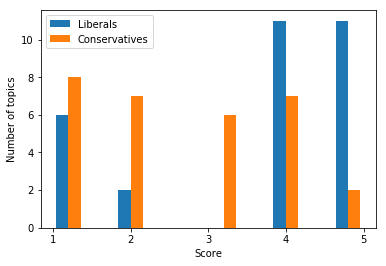

In [11]:
lib_count = main_df[(main_df.ideology=='Liberal')].groupby(['topic', 'email']).agg({'user_stance': lambda x : list(x)[0]})['user_stance'].tolist()
con_count = main_df[(main_df.ideology=='Conservative')].groupby(['topic', 'email']).agg({'user_stance': lambda x : list(x)[0]})['user_stance'].tolist()
plt.hist([lib_count, con_count], label=['Liberals', 'Conservatives'])
plt.legend()
plt.xticks([1,2,3,4,5])
plt.xlabel('Score')
plt.ylabel('Number of topics')
plt.savefig('stance_dist.pdf')  
plt.show()

### Annotator's agreement:

In [12]:
from scipy.stats import kendalltau
import kendall_w as kw

In [13]:
topics = set(main_df.topic.tolist())

In [14]:
def compute_kendalls(main_df):
    kw_scores = []
    for topic in topics:
        for stance in ['pro', 'con']:
            instance_ranking_df = main_df[(main_df.topic==topic) & (main_df.arg_stance==stance)].groupby('email').agg({'rank': lambda x: list(x)}).reset_index()
            instance_ranking = instance_ranking_df['rank'].tolist()
            instance_ranking = np.array(instance_ranking).T.tolist() #invert to we have in the rows the arguments and in the columns the ranks of the annotators
            #print(instance_ranking)
            kw_scores.append(kw.compute_w(instance_ranking))

    return round(np.mean(kw_scores), 3)

In [15]:
print('All: {}'.format(compute_kendalls(main_df)))
print('Lib: {}'.format(compute_kendalls(main_df[main_df.ideology=='Liberal'])))
print('Con: {}'.format(compute_kendalls(main_df[main_df.ideology=='Conservative'])))

All: 0.29
Lib: 0.356
Con: 0.511


#### All results:

Here we consider all users regardless of their political ideology. This mean each instance (ranking 3 arguments) was evaluated
by six annotators.

- Taking individual judgements:

In [187]:
argument_ranks(main_df, aggregate=False)

              rank-1    rank-2    rank-3    avg-rank    agreement
----------  --------  --------  --------  ----------  -----------
binding         0.24      0.32      0.44        2.2             1
individual      0.45      0.38      0.17        1.72            1
general         0.31      0.3       0.39        2.08            1


- Taking the majority rank from the six annotator:

In [188]:
argument_ranks(main_df, aggregate=False)

              rank-1    rank-2    rank-3    avg-rank    agreement
----------  --------  --------  --------  ----------  -----------
binding         0.24      0.32      0.44        2.2             1
individual      0.45      0.38      0.17        1.72            1
general         0.31      0.3       0.39        2.08            1


- In general, morally framed arguments showed to be more effective than general arguments.
- In general, arguments focusing on the individual morals, are best ranked.

#### A look at the liberals:

In [189]:
lib_df = main_df[main_df.ideology == 'Liberal']

- Results show that Liberals ranked binding-arguments more effective than the individual and general arguments (if we consdier both rank-1 and rank-2 against rank-3).

In [190]:
argument_ranks(lib_df, aggregate=False)

              rank-1    rank-2    rank-3    avg-rank    agreement
----------  --------  --------  --------  ----------  -----------
binding         0.23      0.37       0.4        2.17            1
individual      0.4       0.4        0.2        1.8             1
general         0.37      0.23       0.4        2.03            1


In [192]:
argument_ranks(lib_df, aggregate=True)

[2, 3, 1]
returning -1
[2, 1, 3]
returning -1
[3, 2, 3]
[3, 2, 2]
[3, 2, 2]
[2, 3, 2]
[1, 3, 2]
returning -1
[3, 3, 3]
[2, 2, 3]
[3, 2, 3]
[1, 2, 3]
returning -1
[2, 3, 3]
[2, 3, 3]
[2, 1, 3]
returning -1
[2, 1, 3]
returning -1
[1, 1, 3]
[1, 1, 1]
[1, 3, 2]
returning -1
[1, 2, 2]
[1, 2, 3]
returning -1
[1, 1, 2]
[3, 2, 1]
returning -1
[1, 3, 2]
returning -1
[2, 3, 1]
returning -1
[1, 1, 1]
[3, 2, 1]
returning -1
[2, 1, 1]
[2, 2, 2]
[3, 1, 2]
returning -1
[2, 3, 1]
returning -1
[2, 1, 1]
[1, 1, 2]
[1, 1, 2]
[1, 3, 2]
returning -1
[1, 3, 2]
returning -1
[2, 2, 2]
[2, 2, 2]
[3, 2, 1]
returning -1
[3, 1, 1]
[3, 3, 2]
[3, 2, 3]
[1, 3, 2]
returning -1
[2, 1, 1]
[1, 1, 3]
[2, 3, 3]
[1, 1, 3]
[3, 2, 3]
[1, 1, 1]
[1, 3, 1]
[1, 1, 2]
[3, 3, 2]
[3, 2, 1]
returning -1
[3, 2, 1]
returning -1
[3, 2, 1]
returning -1
[3, 2, 1]
returning -1
[3, 3, 1]
[3, 3, 3]
[2, 1, 3]
returning -1
[2, 3, 3]
[2, 1, 1]
              rank-1    rank-2    rank-3    avg-rank    agreement
----------  --------  --------  ---

Now lets invistigate how effectiveness differs if the annotators have the same stance or opposing stance to the provided arguments:

- Liberals were decisive with their stance. They were always either pro or con, but not no-stance.

In [193]:
lib_df[lib_df['arg-type']=='binding']['same_stance'].value_counts()

same    30
diff    30
Name: same_stance, dtype: int64

In [194]:
argument_ranks(lib_df[lib_df['same_stance']=='same'], aggregate=False)

              rank-1    rank-2    rank-3    avg-rank    agreement
----------  --------  --------  --------  ----------  -----------
binding         0.2       0.33      0.47        2.27            1
individual      0.37      0.43      0.2         1.83            1
general         0.43      0.23      0.33        1.9             1


- When arguments have different stance to the liberals, arguments focusing on their morals (individual-arguments) becamse more effective? (Weak signal)

In [195]:
argument_ranks(lib_df[lib_df['same_stance']=='diff'], aggregate=False)

              rank-1    rank-2    rank-3    avg-rank    agreement
----------  --------  --------  --------  ----------  -----------
binding         0.27      0.4       0.33        2.07            1
individual      0.43      0.37      0.2         1.77            1
general         0.3       0.23      0.47        2.17            1


#### A look at the Concervatives:

In [179]:
con_df = main_df[main_df.ideology == 'Conservative']
#con_df = con_df[con_df.user_stance != 3]

- Results show that Conservatives ranked individual-arguments more effective than the binding and general arguments.
- Conservatives seem to be more affected by moral-arguments

In [182]:
argument_ranks(con_df, aggregate=False)

              rank-1    rank-2    rank-3    avg-rank    agreement
----------  --------  --------  --------  ----------  -----------
binding         0.25      0.27      0.48        2.23            1
individual      0.5       0.37      0.13        1.63            1
general         0.25      0.37      0.38        2.13            1


Now lets invistigate how effectiveness differs if the annotators have the same stance or opposing stance to the provided arguments:

In [99]:
con_df[con_df['arg-type']=='binding']['same_stance'].value_counts()

same    24
diff    24
unk     12
Name: same_stance, dtype: int64

In [100]:
argument_ranks(con_df[con_df['same_stance']=='same'], aggregate=False)

              rank-1    rank-2    rank-3    avg-rank    agreement
----------  --------  --------  --------  ----------  -----------
binding         0.25      0.21      0.54        2.29            1
individual      0.5       0.29      0.21        1.71            1
general         0.25      0.5       0.25        2               1


In [101]:
argument_ranks(con_df[con_df['same_stance'] == 'diff'], aggregate=False)

              rank-1    rank-2    rank-3    avg-rank    agreement
----------  --------  --------  --------  ----------  -----------
binding         0.17      0.21      0.62        2.46            1
individual      0.5       0.46      0.04        1.54            1
general         0.33      0.33      0.33        2               1


In [102]:
argument_ranks(con_df[con_df['same_stance']=='unk'], aggregate=False)

              rank-1    rank-2    rank-3    avg-rank    agreement
----------  --------  --------  --------  ----------  -----------
binding         0.42      0.5       0.08        1.67            1
individual      0.5       0.33      0.17        1.67            1
general         0.08      0.17      0.75        2.67            1


In [107]:
argument_ranks(con_df[con_df['same_stance']!='same'], aggregate=False)

              rank-1    rank-2    rank-3    avg-rank    agreement
----------  --------  --------  --------  ----------  -----------
binding         0.25      0.31      0.44        2.19            1
individual      0.5       0.42      0.08        1.58            1
general         0.25      0.28      0.47        2.22            1


-------

### Computing confidence intervals:

How to report on this? https://www.statology.org/how-to-report-confidence-intervals/

In [14]:
from statsmodels.stats.weightstats import *

In [62]:
print('Indvidualizing Vs. Non-moral for All:')

indi_arg_ranks = main_df[(main_df['arg-type'].isin(['individual']))]['rank'].tolist() #we average the scores of moral arguments
nonmoral_arg_ranks = main_df[(main_df['arg-type'] == 'general')]['rank'].tolist()

print('T-test:', check_sig(nonmoral_arg_ranks, indi_arg_ranks, alpha=0.05))
cm = CompareMeans.from_data(np.array(nonmoral_arg_ranks), np.array(indi_arg_ranks))
cm.summary(alpha=0.05)

Indvidualizing Vs. Non-moral for All:
Distribution is not normal, so using wilcoxon
T-test: True


,coef,std err,t,P>|t|,[0.025,0.975]
subset #1,0.3667,0.102,3.607,0.000,0.166,0.567


In [70]:
print('Moral Vs. Non-moral for Liberals:')

df = main_df[(main_df['same_stance']=='diff') & (main_df['ideology']=='Liberal')]


avg_moral_arg_ranks = main_df[(main_df['arg-type'].isin(['binding', 'individual']))].groupby(['topic', 'arg_stance', 'email']).agg({'rank': lambda x: np.mean(x)}).reset_index()['rank'].tolist() #we average the scores of moral arguments
nonmoral_arg_ranks = main_df[(main_df['arg-type'] == 'general')]['rank'].tolist()

print('T-test:', check_sig(nonmoral_arg_ranks, avg_moral_arg_ranks, alpha=0.1))
cm = CompareMeans.from_data(np.array(nonmoral_arg_ranks), np.array(avg_moral_arg_ranks))
cm.summary(alpha=0.1)

Moral Vs. Non-moral for Liberals:
Distribution is not normal, so using wilcoxon
T-test: True


,coef,std err,t,P>|t|,[0.05,0.95]
subset #1,0.1250,0.085,1.465,0.144,-0.016,0.266


In [46]:
print('Moral Vs. Non-moral for All:')

avg_moral_arg_ranks = main_df[(main_df['arg-type'].isin(['binding', 'individual']))].groupby(['topic', 'arg_stance', 'email']).agg({'rank': lambda x: np.mean(x)}).reset_index()['rank'].tolist() #we average the scores of moral arguments
nonmoral_arg_ranks = main_df[(main_df['arg-type'] == 'general')]['rank'].tolist()

print('T-test:', check_sig(nonmoral_arg_ranks, avg_moral_arg_ranks, alpha=0.1))
cm = CompareMeans.from_data(np.array(nonmoral_arg_ranks), np.array(avg_moral_arg_ranks))
cm.summary(alpha=0.1)

Moral Vs. Non-moral for All:
Distribution is not normal, so using wilcoxon
T-test: True


,coef,std err,t,P>|t|,[0.05,0.95]
subset #1,0.1250,0.085,1.465,0.144,-0.016,0.266


In [45]:
print('Moral Vs. Non-moral for All, considering challanging arguments:')

df = main_df[main_df['same_stance']=='diff']

avg_moral_arg_ranks = df[(df['arg-type'].isin(['binding', 'individual']))].groupby(['topic', 'arg_stance', 'email']).agg({'rank': lambda x: np.mean(x)}).reset_index()['rank'].tolist() #we average the scores of moral arguments
nonmoral_arg_ranks = df[(df['arg-type'] == 'general')]['rank'].tolist()
print('Non-moral arguments\'s ranks are significantly lower than moral arguments: ', check_sig(nonmoral_arg_ranks, avg_moral_arg_ranks, alpha=0.1))
cm = CompareMeans.from_data(np.array(nonmoral_arg_ranks), np.array(avg_moral_arg_ranks))
cm.summary(alpha=0.1)

Moral Vs. Non-moral for All, considering challanging arguments:
Distribution is not normal, so using wilcoxon
Non-moral arguments's ranks are significantly lower than moral arguments:  False


,coef,std err,t,P>|t|,[0.05,0.95]
subset #1,0.1389,0.130,1.071,0.287,-0.076,0.354


In [76]:
print('Moral Vs. Non-moral for Conservatives:')
df = main_df[main_df['ideology'] == 'Conservative']

avg_moral_arg_ranks = df[(df['arg-type'].isin(['binding', 'individual']))].groupby(['topic', 'arg_stance', 'email']).agg({'rank': lambda x: np.mean(x)}).reset_index()['rank'].tolist() #we average the scores of moral arguments
nonmoral_arg_ranks = df[(df['arg-type'] == 'general')]['rank'].tolist()

print('Non-moral arguments\'s ranks are significantly lower than moral arguments for Conservatives: ', check_sig(nonmoral_arg_ranks, avg_moral_arg_ranks, alpha=0.1))
cm = CompareMeans.from_data(np.array(nonmoral_arg_ranks), np.array(avg_moral_arg_ranks))
cm.summary(alpha=0.1)

Moral Vs. Non-moral for Conservatives:
Distribution is not normal, so using wilcoxon
Non-moral arguments's ranks are significantly lower than moral arguments for Conservatives:  True


,coef,std err,t,P>|t|,[0.05,0.95]
subset #1,0.2000,0.114,1.751,0.082,0.011,0.389


In [53]:
print('Individualizing vs. Binding for liberals:')

df = main_df[main_df['ideology'] == 'Liberal']

binding_ranks = df[(df['arg-type'].isin(['binding']))]['rank'].tolist() #we average the scores of moral arguments
indi_ranks = df[(df['arg-type'].isin(['individual']))]['rank'].tolist() #we average the scores of moral arguments

print('Non-moral arguments\'s ranks are significantly lower than moral arguments: ', check_sig(binding_ranks, indi_ranks, alpha=0.1))
cm = CompareMeans.from_data(np.array(binding_ranks), np.array(indi_ranks))
cm.summary(alpha=0.1)

Individualizing vs. Binding for liberals:
Distribution is not normal, so using wilcoxon
Non-moral arguments's ranks are significantly lower than moral arguments:  True


,coef,std err,t,P>|t|,[0.05,0.95]
subset #1,0.3667,0.141,2.609,0.010,0.134,0.600


In [77]:
print('Binding vs. non-moral for Conservatives, when arguments are challanging:')

df = main_df[(main_df['ideology'] == 'Conservative') & (main_df['same_stance'] == 'diff')]

binding_ranks = df[(df['arg-type'].isin(['binding']))]['rank'].tolist() #we average the scores of moral arguments
nonmoral_ranks = df[(df['arg-type'].isin(['general']))]['rank'].tolist() #we average the scores of moral arguments

print('Non-moral arguments\'s ranks are significantly lower than moral arguments: ', check_sig(nonmoral_ranks, binding_ranks, alpha=0.1))
cm = CompareMeans.from_data(np.array(nonmoral_ranks), np.array(binding_ranks))
cm.summary(alpha=0.1)

Binding vs. non-moral for Conservatives, when arguments are challanging:
Distribution is not normal, so using wilcoxon
Non-moral arguments's ranks are significantly lower than moral arguments:  False


,coef,std err,t,P>|t|,[0.05,0.95]
subset #1,-0.4583,0.233,-1.967,0.055,-0.849,-0.067


In [26]:
main_df.head()

,email,ideology,user_stance,arg_stance,topic,arg-type,rank,same_stance
0,onnaday@onnaday.com,Liberal,1,pro,death-penalty,binding,2,diff
1,onnaday@onnaday.com,Liberal,1,pro,death-penalty,individual,3,diff
2,onnaday@onnaday.com,Liberal,1,pro,death-penalty,general,1,diff
3,onnaday@onnaday.com,Liberal,1,con,death-penalty,binding,3,same
4,onnaday@onnaday.com,Liberal,1,con,death-penalty,individual,1,same


--------

#### Follow-up quesionnaire:

In [62]:
ls ../../../computational-moral-foundations/moral-based-argumentation/data/moral-survey

moral-foundation-main-study.csv  moral-foundation-part2-responses.csv


In [63]:
df = pd.read_csv(data_fold_path + 'moral-survey/moral-foundation-followup-questionnaire.csv')

In [64]:
df.head(n=10)

,Timestamp,Email Address,"YOUR VIEWS: When arguments contested your stance on the topic, which of the following arguments did you see as more effective:","YOUR KNOWLEDGE: When arguments contested your stance on the topic, which of the following arguments did you see as more effective","OTHERS' VIEWS: When arguments contested your stance on the topic, which of the following arguments did you see as more effective","When arguments contested your stance on the topic, which of the above three was most important for you to judge about effectiveness:","YOUR VIEWS: When arguments had similar stance to yours, which of the following arguments did you see as more effective:","YOUR KNOWLEDGE: When arguments has similar stance to yours, which of the following arguments did you see as more effective","OTHERS' VIEWS: When arguments had similar stance to yours, which of the following arguments did you see as more effective","When arguments had similar stance to yours, which of the above three was most important for you to judge about effectiveness:",Are there are other important factors that influenced your judgment of the effectiveness:
0,7/21/2021 22:38:42,bret.thurman0129@gmail.com,Arguments that challenged your views,Arguments that introduce views you were not fa...,Neither of those was important,Others' views,Arguments that challenged your views,Arguments that introduce views you were not fa...,Arguments you saw as particularly convincing t...,Others' views,NaN
1,7/21/2021 23:22:52,onnaday@onnaday.com,Neither of those was important,Arguments that introduce views you were not fa...,Arguments you saw as particularly convincing t...,Your knowledge,Arguments that matched your views,Arguments that introduce views you were not fa...,Arguments you saw as particularly convincing t...,Your knowledge,One's presentation of their views is something...
2,7/22/2021 1:16:07,mollynm@gmail.com,Neither of those was important,Arguments that introduce views you were not fa...,Arguments you saw as particularly convincing t...,Others' views,Arguments that matched your views,Arguments based on views you already knew about,Arguments you saw as particularly convincing t...,Your knowledge,Some other factors that influenced my judgemen...
3,7/22/2021 7:55:45,faith.brandi@gmail.com,Arguments that challenged your views,Arguments that introduce views you were not fa...,Arguments you saw as particularly convincing t...,Your knowledge,Arguments that matched your views,Arguments based on views you already knew about,Arguments you saw as particularly convincing t...,Your knowledge,Arguments that were free from grammatical erro...
4,7/23/2021 16:06:31,mikestroup@suddenlink.net,Arguments that challenged your views,Neither of those was important,Neither of those was important,Your knowledge,Neither of those was important,Arguments that introduce views you were not fa...,Neither of those was important,Your knowledge,Verifiable acts and logical arguments speak mu...
5,7/25/2021 0:56:09,mpy2@aol.com,Arguments that matched your views,Arguments that introduce views you were not fa...,Arguments you saw as particularly convincing t...,Your knowledge,Arguments that challenged your views,Arguments that introduce views you were not fa...,Arguments you saw as particularly convincing t...,Your knowledge,pertinent evidence and actual consequences


In [69]:
data = []

for idx, row in df.iterrows():
    ideology = users_ideology_map[row['Email Address']]
    for clm in df.columns.tolist()[2:-1]:
        data.append([ideology, 'challanging' if 'contested' in clm else 'empowering', clm, row[clm]])

new_df = pd.DataFrame(data, columns=['ideology', 'argument_type', 'question', 'answer_option'])

In [78]:
new_df.answer_option.value_counts()

Arguments that introduce views you were not familiar with                               9
Your knowledge                                                                          9
Arguments you saw as particularly convincing to people that rather oppose your views    8
Neither of those was important                                                          7
Arguments that challenged your views                                                    5
Arguments that matched your views                                                       4
Others' views                                                                           3
Arguments based on views you already knew about                                         2
Arguments you saw as particularly convincing to people that share your views            1
Name: answer_option, dtype: int64

In [79]:
new_df.to_csv('../../../computational-moral-foundations/moral-based-argumentation/data/moral-survey/processed_follow_up_study.csv')

YOUR VIEWS: When arguments contested your stance on the topic, which of the following arguments did you see as more effective:
{'Arguments that challenged your views': 3, 'Neither of those was important': 2, 'Arguments that matched your views': 1}



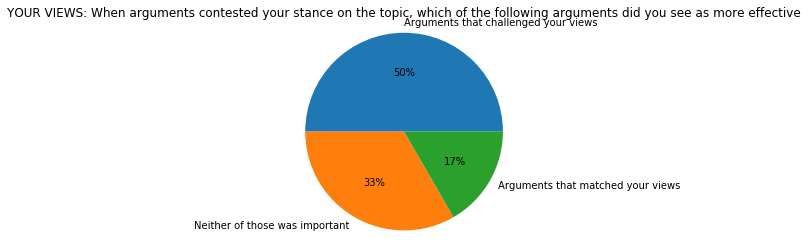

YOUR KNOWLEDGE: When arguments contested your stance on the topic, which of the following arguments did you see as more effective
{'Arguments that introduce views you were not familiar with': 5, 'Neither of those was important': 1}



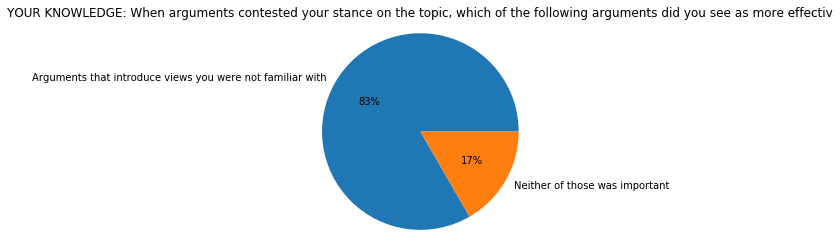

OTHERS' VIEWS: When arguments contested your stance on the topic, which of the following arguments did you see as more effective
{'Arguments you saw as particularly convincing to people that rather oppose your views': 4, 'Neither of those was important': 2}



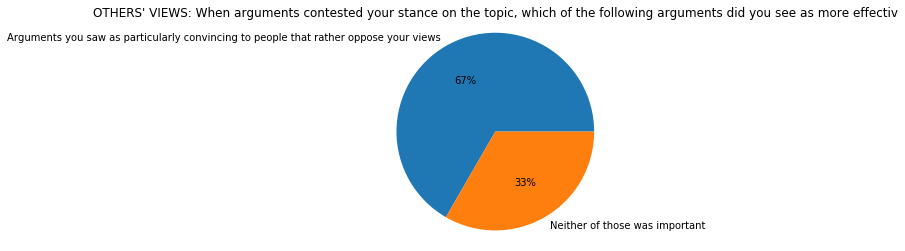

When arguments contested your stance on the topic, which of the above three was most important for you to judge about effectiveness:
{'Your knowledge': 4, "Others' views": 2}



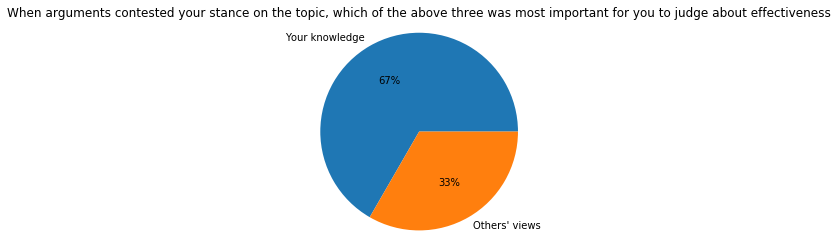

YOUR VIEWS: When arguments had similar stance to yours, which of the following arguments did you see as more effective:
{'Arguments that matched your views': 3, 'Arguments that challenged your views': 2, 'Neither of those was important': 1}



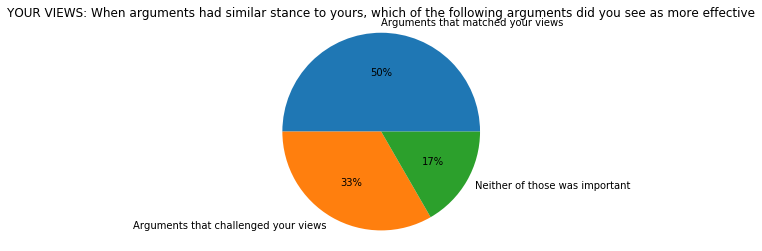

YOUR KNOWLEDGE: When arguments has similar stance to yours, which of the following arguments did you see as more effective
{'Arguments that introduce views you were not familiar with': 4, 'Arguments based on views you already knew about': 2}



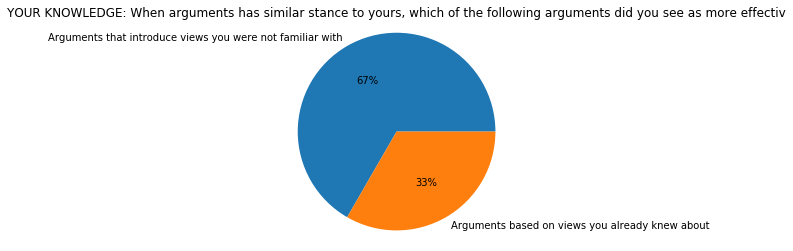

OTHERS' VIEWS: When arguments had similar stance to yours, which of the following arguments did you see as more effective
{'Arguments you saw as particularly convincing to people that rather oppose your views': 4, 'Arguments you saw as particularly convincing to people that share your views': 1, 'Neither of those was important': 1}



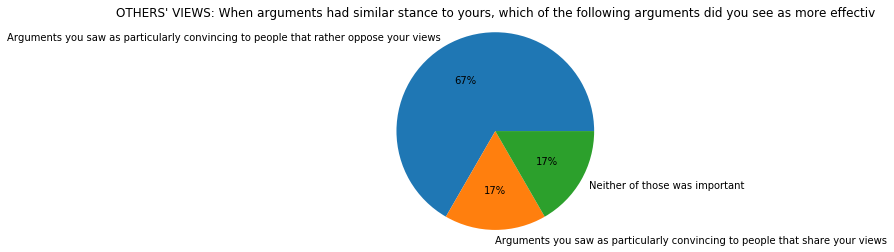

When arguments had similar stance to yours, which of the above three was most important for you to judge about effectiveness:
{'Your knowledge': 5, "Others' views": 1}



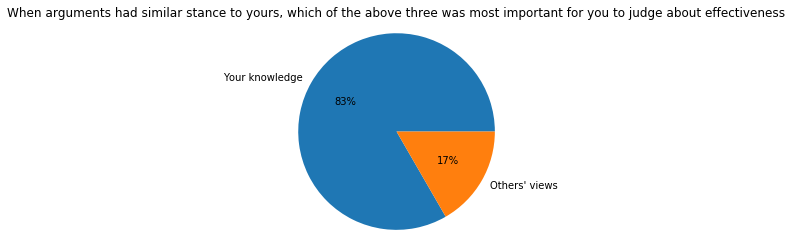

In [65]:

for i, clm in enumerate(df.columns[2:-1]):
    print(clm)
    print(df[clm].value_counts().to_dict())
    print('==============')
    print()
    
    s = df[clm].value_counts().to_dict()
    labels = s.keys()
    values = s.values()
    #plt.bar(labels, values, label='yo')
    plt.pie(values, labels=labels, autopct='%1.0f%%')
    plt.gca().axis("equal")
    #plt.legend()
    #plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
    plt.title(clm[0:-1])
    plt.savefig('followup-results-{}.pdf'.format(i))
    plt.show()